### **Welcome to the STELA Toolkit!**

The **STELA Toolkit** is designed for studying variability in light curves, mainly through powerful **frequency-domain data products**, including power and cross spectra, time lags, and coherences. 

By using **Gaussian process (GP) modeling** to interpolate uneven light curves onto a regular time grid, STELA allows you to carry out Fourier-based analyses as if your data were perfectly sampled. That said, if your data is already regularly sampled, you can use STELA just as easily—GPs are completely optional.

In addition to frequency-domain tools, STELA also supports time-domain lag analysis using the cross-correlation function (CCF). For irregularly sampled data, you can choose between modeling the light curves with GPs or using the widely adopted interpolated cross-correlation function (ICCF) method, which linearly interpolates one time series onto the other’s grid.

STELA was designed to be convenient and intuitive, regardless of your background in Python or statistics. If you ever run into trouble—whether it’s a bug, something confusing, or a suggestion for how STELA could serve you better—I’d love to hear from you. Please open an issue on the [GitHub Issues Page](https://github.com/collinlewin/stela-toolkit/issues), or feel free to email me directly: Collin Lewin (clewin@mit.edu).

##### *In this tutorial, you’ll learn how to...*
1. **Import, clean, and plot** time series data
2. Model variability using **Gaussian processes (GPs)**
3. **Predict new values** of the time series at previously unobserved times
4. Generate powerful **frequency-domain and lag-based data products**
6. **Simulate light curves** with custom variability and response/lag properties

In [2]:
# Import STELA
from stela_toolkit import *

import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

#### **Importing Your Data**
---

All core functionality in the STELA Toolkit begins with time series data, which we represent using the `LightCurve` class. You can create a `LightCurve` object in one of two ways:

1. **From a file**  
   STELA supports text-based formats like `.dat`, `.txt`, and `.csv`, as well as FITS files. By default, it assumes the first three columns in the file contain:
   - Time
   - Measured values (e.g., flux or count rate)
   - Measurement uncertainties

   If your file uses different columns, you can specify which ones to use with the `file_columns` argument.

2. **From NumPy arrays**  
   You can also construct a light curve directly by passing arrays for time, values, and uncertainties.

> *Tip:* Once you’ve created a `LightCurve`, you can pass it to any STELA analysis tool: modeling, frequency-domain transforms, or lag computations.

Below, we’ll load and plot data from the AGN NGC 5548, observed by the Swift Observatory as part of the AGN STORM campaign.

In [3]:
# Option 1: Load light curve directly from a text file
lightcurve = LightCurve(file_path='../data/NGC5548_U_swift.dat')

# Option 2: Or from arrays
data = np.genfromtxt(f'../data/NGC5548_X_swift.dat')
lightcurve = LightCurve(times=data[:, 0], rates=data[:, 1], errors=data[:, 2])

#### **Plotting Data and Results**
---

STELA makes it easy to preview and customize plots of your light curve—and not just light curves. **Every main class in the toolkit** (from power spectra to lag measurements) includes a `.plot()` method with a consistent structure, so once you learn it, you can apply it everywhere.

Almost every visual element of the plot can be customized using keyword arguments:

- Basic plot settings like `xlabel`, `ylabel`, `title`, `figsize`, `xscale`, and `yscale`
- Advanced customization via `plot_kwargs`, `fig_kwargs`, `tick_kwargs`, etc.
- Save options using `save` and `save_kwargs`

This makes it easy to generate quick diagnostic plots or high-quality figures for publications.

Let’s start with a simple plot, followed by a fully customized one.

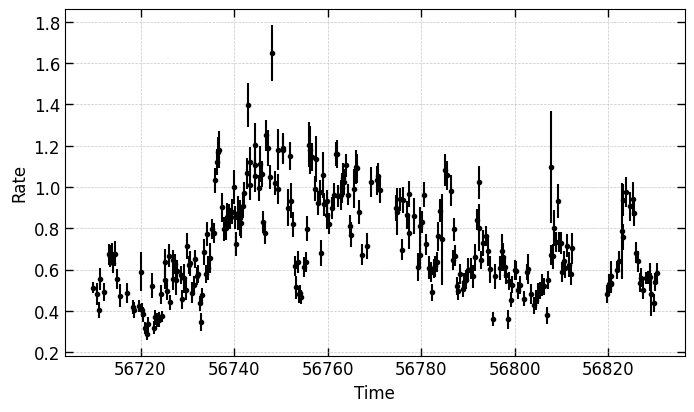

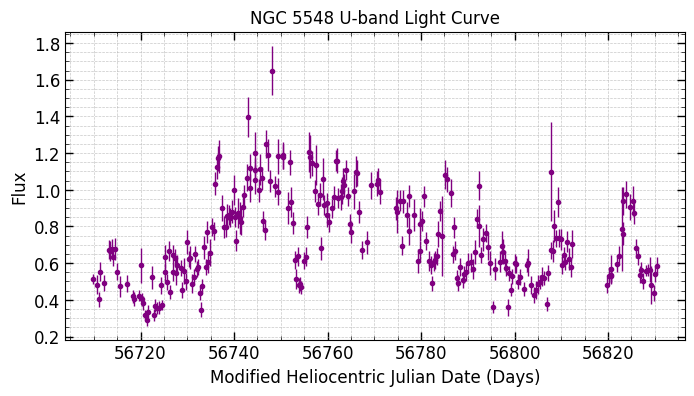

In [4]:
# Basic plot
lightcurve.plot()

# Customized plot
lightcurve.plot(
    figsize=(8, 4),
    xlabel='Modified Heliocentric Julian Date (Days)',
    ylabel='Flux',
    xlim=(lightcurve.times[0], lightcurve.times[-1]),
    title='NGC 5548 U-band Light Curve',
    plot_kwargs={'color': 'purple', 'fmt': 'o', 'lw': 1, 'ms': 3},
    major_tick_kwargs={'direction': 'in', 'top': True, 'right': True, 'length': 6, 'width': 1},
    minor_tick_kwargs={'direction': 'in', 'top': True, 'right': True, 'length': 3, 'width': 0.5}
    # save='my_plot.png', savefig_kwargs={'dpi': 300}
)

### **Data Preprocessing and Cleaning**
---

Before modeling or computing spectral products, it’s often helpful to inspect and clean your light curve. STELA provides a number of tools to help you do this safely and flexibly.

All preprocessing tools live in the `Preprocessing` class. You don’t need to create an instance—just call the methods directly.

Most of these functions let you:
- **Visualize changes** with `plot=True`
- **Avoid committing changes** by setting `save=False` (recommended for first passes)
- Clean data **without modifying the original file or LightCurve object**

Common tasks include:

- `remove_nans()` — drop entries with missing data
- `remove_outliers()` — exclude extreme points using the interquartile range (IQR)
- `trim_time_segment()` — keep only part of the light curve (e.g., for campaign segmentation)
- `polynomial_detrend()` — subtract long-term trends before analysis
- `standardize()` and `unstandardize()` — mean-center and rescale your data

Here’s how to explore these features in practice:


Removed 0 NaN points.
(0 NaN rates, 0 NaN errors)
Removed 11 outliers (4.14% of data).


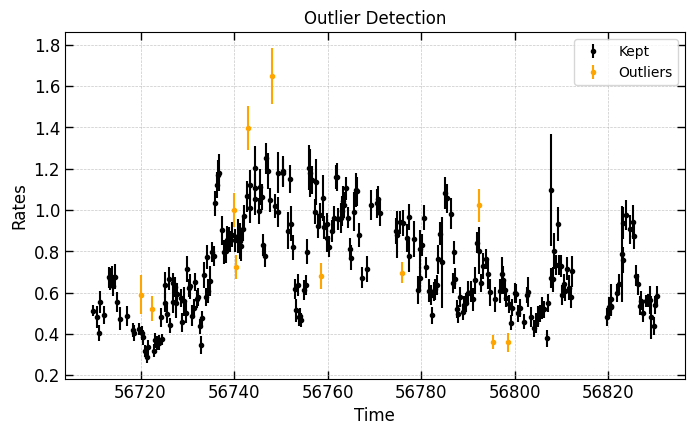

Removed 3 outliers (1.13% of data).


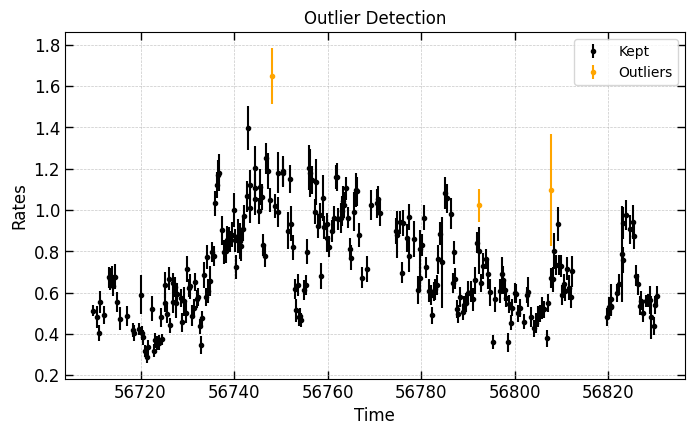

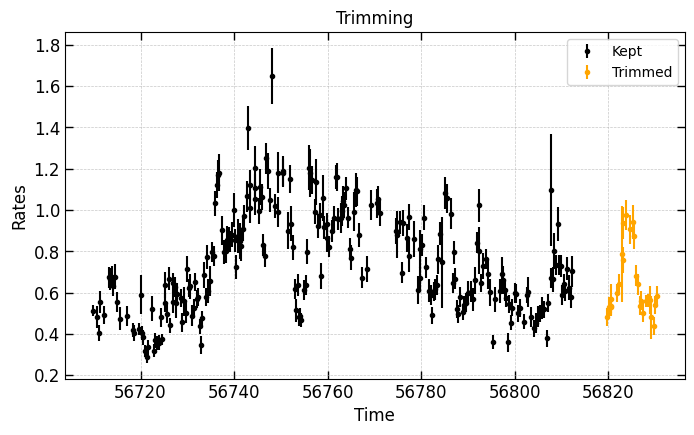

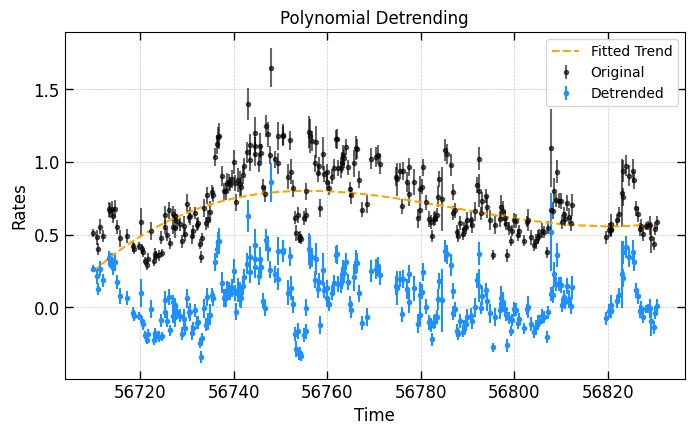

In [5]:
# Remove any NaNs in the time, flux, or error arrays
Preprocessing.remove_nans(lightcurve)

# Explore outlier removal using a rolling IQR window, or a global IQR (set rolling_window = None)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=10, plot=True, verbose=True, save=False)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=50, plot=True, verbose=True, save=False)

# Trim the light curve to a specific observing window
Preprocessing.trim_time_segment(lightcurve, end_time=56815, plot=True, save=False)

# Detrend the light curve using a polynomial fit (here, degree 3)
Preprocessing.polynomial_detrend(lightcurve, degree=3, plot=True, save=False)

# Standardize the light curve (zero mean, unit variance)
Preprocessing.standardize(lightcurve)
Preprocessing.unstandardize(lightcurve)

#### **Checking for Normality**
---

Before fitting a Gaussian Process model, it's important to check whether your light curve's flux distribution is **approximately normal**. Gaussian processes assume the data is drawn from a Gaussian distribution, so significant departures from normality can hurt performance or lead to unstable fits.

STELA gives you a few tools in the `Preprocessing` class to assess and correct this via transformations:

- **`generate_qq_plot()`**: Plots a Q-Q (quantile-quantile) comparison of your data against a normal distribution. If the points fall roughly on a straight 1:1 line, the data is reasonably normal.
- **`check_normal()`**: Performs a formal statistical test for normality at significance level of 0.05. STELA automatically chooses the most appropriate test depending on your sample size, using Shapiro-Wilk for small sample (n<50) and Lilliefors for larger ones (n>50). A Q-Q plot can also be produced here using `plot=True`.
- **`check_boxcox_normal()`**: Applies a Box-Cox transformation and re-runs the normality test to see the degree to which the transformation improves normality. A Q-Q plot with both the original and transformed data overlaid can also be produced here using `plot=True`.

*Note:* The Box-Cox transform is a power-law transformation that reshapes the data to better resemble a normal distribution, and STELA automatically optimizes the transformation parameter (λ) for your dataset.

> **Don't want to do all this beforehand?** Use the `enforce_normality=True` in the `GaussianProcess` class (see below). 


Let’s try it out and see how our light curve looks.

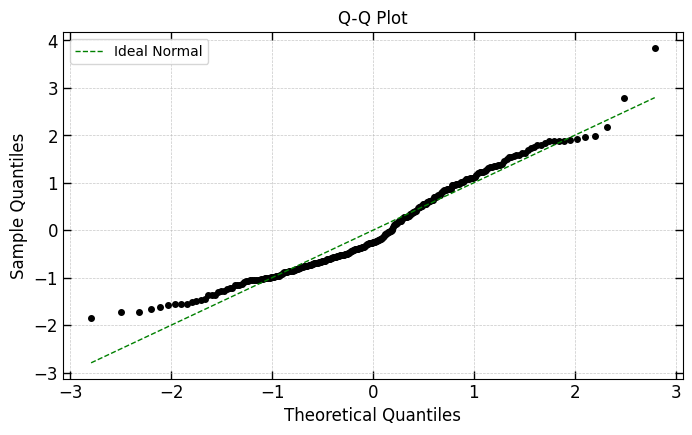

Using Lilliefors test (for n >= 50)
Lilliefors (modified KS) test p-value: 0.001
  -> Very strong evidence against normality (p = 0.001)
     - Consider running `check_boxcox_normal()` to see if a Box-Cox transformation can help.
     - Often checking normality via a Q-Q plot (run `generate_qq_plot(lightcurve)`) is sufficient.
Before Box-Cox:
----------------
Using Lilliefors test (for n >= 50)
Lilliefors (modified KS) test p-value: 0.001
  -> Very strong evidence against normality (p = 0.001)
     - Consider running `check_boxcox_normal()` to see if a Box-Cox transformation can help.
     - Often checking normality via a Q-Q plot (run `generate_qq_plot(lightcurve)`) is sufficient.
After Box-Cox:
----------------
Using Lilliefors test (for n >= 50)
Lilliefors (modified KS) test p-value: 0.0549
  -> Little to no evidence against normality (p = 0.0549)


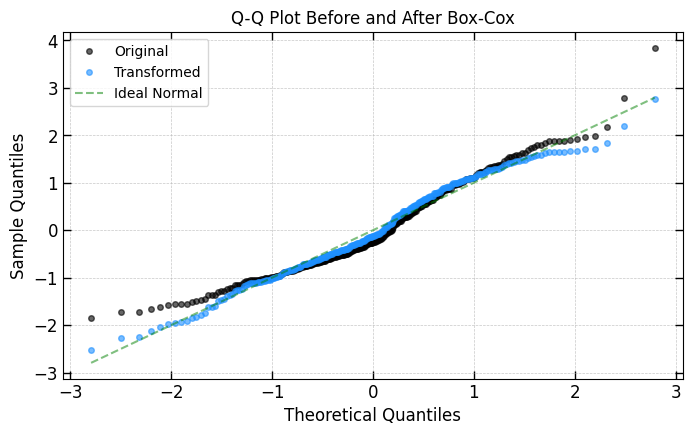

(True, 0.05493661102559335)

In [6]:
# the Q-Q plot already appears reasonable, although the tails here seem nonnormal, or our normal is skewed
Preprocessing.generate_qq_plot(lightcurve)

# test indicates that the data is not normal
Preprocessing.check_normal(lightcurve, plot=False)

# our boxcox transformation helps!
Preprocessing.check_boxcox_normal(lightcurve, plot=True)

### **Gaussian Process Models in STELA**
---

To model light curve variability in STELA, we use the `GaussianProcess` class. In summary, a **Gaussian Process (GP)** is a flexible, non-parametric model that treats your data as samples drawn from a multivariate normal distribution, with covariance determined by a *kernel function*. This allows us to infer what the light curve may have looked like between or beyond the observed times, while also accounting for uncertainty in a principled way.

> If you’d rather not check for normality yourself (as in the previous section), simply set `enforce_normality=True`. STELA will automatically assess whether your light curve’s flux distribution is sufficiently Gaussian, and if not, apply a Box-Cox transformation. It will then recheck the transformed data to confirm whether normality has improved.

> Want to learn more on GPs?  
> Read the [Introduction to Gaussian Processes]() part of the documentation (under construction, this won't work yet) to understand the theory behind what we’re doing here.


In STELA, you pass your `LightCurve` object to the `GaussianProcess` class to create the model.

---

#### **Kernel Functions**

The covariance function—or *kernel*—controls how the model expects different points in time to relate to one another. Later in the tutorial we introduce method for how to go about choosing a functional form. STELA includes several kernel options, specified via the `kernel_form` argument:

1. **Radial Basis Function (RBF)** – very smooth
2. **Rational Quadratic (RQ)** – similar to RBF, but with variable smoothness and an additional hyperparameter
3. **Matern kernels** – less smooth; controlled by ν:
   - `Matern12` (ν = 1/2)
   - `Matern32` (ν = 3/2)
   - `Matern52` (ν = 5/2)
   > *(Note: ν is a fixed kernel parameter, not a hyperparameter to be optimized)*
4. **Spectral Mixture kernel** – captures periodic or quasi-periodic behavior  
   - Syntax: `"SpectralMixture, N"` sets the number of mixtures to `N` (e.g., `"SpectralMixture, 4"`)

---

#### **Error and Noise Handling**

STELA’s GP models automatically incorporate your observational errors **if you’ve provided them** in the `LightCurve`. These act as fixed noise levels for each data point in the likelihood.

In addition, you can optionally fit an **extra white noise component** to account for unmodeled variability. This is enabled via ``white_noise=True``.

---

### **Setting Up a GP Model**
---

You can create a `GaussianProcess` model by passing in your `LightCurve` object, along with options for kernel choice, noise modeling, and normality checking. This step only sets up the model—it doesn’t train it yet.

Let’s initialize a model and prepare it for training, although we could just set `run_training=True` for future reference.


In [7]:
gp_model = GaussianProcess(lightcurve, 
                           kernel_form="Matern32", 
                           white_noise=True, 
                           enforce_normality=True, 
                           run_training=False
                        )

Checking normality of input light curve...

 - Light curve is not normal (p = 0.0010). Applying Box-Cox transformation...
 - Normality sufficiently achieved after Box-Cox (p = 0.0549)! Proceed as normal!



### **Training the Model**
---

Once your Gaussian Process model is initialized, you can *train* it to fit your data. This step adjusts the kernel’s hyperparameters (e.g., length scale, amplitude, white noise) so the model best represents the variability in your light curve.

Training is performed by minimizing the **Negative Log Marginal Likelihood (NLML)** — a standard loss function for GPs. It measures how likely your observed data is under the current model.

More precisely, the marginal likelihood is the probability of observing your data given the kernel hyperparameters (e.g., length scale, amplitude), **after integrating over all possible functions** the GP could represent. Lower NLML means the model is assigning higher probability to your observed data.

---

#### **Running Training**

To train your model, call the `.train()` method on your `GaussianProcess` object. This adjusts the kernel’s hyperparameters so the model best fits your light curve.

If you don’t know much about optimization, don’t worry! While the default training settings (`learn_rate=0.1`, `num_iter=500`) are usually sufficient for most light curves and kernels, it's good practice to plot the NLML:

> **Recommended:** Set `plot_training=True`. This will show you how the training loss (NLML) evolves. You want to see the curve decrease and then flatten out by the end — that means the model has reached a stable fit. Otherwise see the subsection below.

---

#### **Training Parameters**

- `num_iter`: how many training steps to take (optional, default 500)
- `learn_rate`: how fast the optimizer updates the parameters (optional, default 0.1)
- `plot`: show a plot of the loss improving over time (optional, default False)
- `verbose`: print optimization details (optional, default False)

---

#### **What to Try if Things Don’t Look Right**

- If the loss curve is **very slowly decreasing**, try increasing `learn_rate` (e.g., to `0.3` or `0.5`)
- If the curve is **bouncy or erratic**, lower `learn_rate` (e.g., to `0.01`)
- If the curve is **still going down at the end**, increase `num_iter` (e.g., to `1000`)


Iter 1/500 - loss: 1.062   lengthscale: 12.056   noise: 5.0e-01
Iter 26/500 - loss: 0.928   lengthscale: 9.354   noise: 1.5e-01
Iter 51/500 - loss: 0.865   lengthscale: 6.520   noise: 9.3e-02
Iter 76/500 - loss: 0.852   lengthscale: 4.779   noise: 7.1e-02
Iter 101/500 - loss: 0.837   lengthscale: 4.151   noise: 7.2e-02
Iter 126/500 - loss: 0.809   lengthscale: 2.665   noise: 6.7e-02
Iter 151/500 - loss: 0.805   lengthscale: 2.023   noise: 5.3e-02
Iter 176/500 - loss: 0.805   lengthscale: 2.118   noise: 6.0e-02
Iter 201/500 - loss: 0.805   lengthscale: 2.099   noise: 5.8e-02
Iter 226/500 - loss: 0.805   lengthscale: 2.102   noise: 5.8e-02
Iter 251/500 - loss: 0.805   lengthscale: 2.103   noise: 5.8e-02
Iter 276/500 - loss: 0.805   lengthscale: 2.102   noise: 5.8e-02
Iter 301/500 - loss: 0.805   lengthscale: 2.102   noise: 5.8e-02
Iter 326/500 - loss: 0.805   lengthscale: 2.102   noise: 5.8e-02
Iter 351/500 - loss: 0.805   lengthscale: 2.102   noise: 5.8e-02
Iter 376/500 - loss: 0.805   

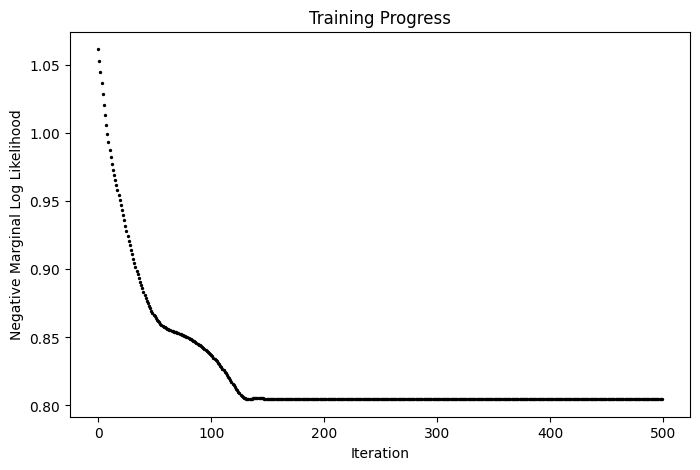

Checking normality of input light curve...

 - Light curve is not normal (p = 0.0010). Applying Box-Cox transformation...
 - Normality sufficiently achieved after Box-Cox (p = 0.0549)! Proceed as normal!



{'likelihood.second_noise_covar.noise': 0.05816479027271271,
 'covar_module.outputscale': 0.8184614181518555,
 'covar_module.base_kernel.lengthscale': 2.101961612701416}

In [8]:
# Train the model manually after initialization
gp_model.train(
    num_iter=500,        # Number of training steps
    learn_rate=0.1,      # Step size for optimizer
    plot=True,           # Show NLML evolution
    verbose=True         # Print progress info
)

# Alternatively: train automatically during initialization
gp_model = GaussianProcess(lightcurve, 
                           kernel_form="Matern32", 
                           white_noise=True, 
                           enforce_normality=True, 
                           run_training=True,
                           plot_training=False,
                           num_iter=500,        
                           learn_rate=0.1, 
                           verbose=False)

# To view the hyperparameters of a model at a later time, use the get_hyperparameters method
gp_model.get_hyperparameters()

# It is good practice to save the model, so that you can load it later for consistency
# Both can be done with the package's save_model and load_model methods
# gp_model.save_model('gp_model.pkl')
# gp_model.load_model('gp_model.pkl')

### **Selecting a Kernel Form**
---

When you create a Gaussian Process model, a key decision is which *kernel* to use. The kernel affects how the model captures the observed variability, including how smooth, erratic, or periodic the signal is. 

This choice directly affects how well the GP can capture the underlying structure of your light curve and thus should be assessed on each light curve independently. 

---

##### **Option 1: Let STELA Select Automatically**

If you're unsure which kernel is best, you can pass `'auto'` or a list of kernel names to `kernel_form`. STELA will try each one, train a model for each (even if `run_training=False`), and select the best based on Akaike Information Criterion (AIC). AIC rewards higher likelihood, and punishes model complexity based on the number of kernel hyperparameters.

##### **Option 2: Compare Kernels Manually**

If you'd like to explore different kernels yourself, you can train them one at a time and compare their AIC/BIC scores manually.

In [57]:
# Option 1: Let STELA select automatically
# Will take a bit longer than normal to train, assess all the models
gp_model = GaussianProcess(lightcurve,
                           kernel_form="auto", # consider all kernels available
                         # kernel_form=["RBF", "Matern32", "RQ", "Matern52"],
                           white_noise=True, 
                           enforce_normality=False, 
                        )  

# Option 2: Compare kernels manually
gp1 = GaussianProcess(lightcurve, kernel_form="RBF", run_training=True)
gp2 = GaussianProcess(lightcurve, kernel_form="Matern32", run_training=True)

print("Kernel Statistics (lower is better for AIC/BIC):")
print("===============================================")

print(f"{'Kernel':<12} {'AIC':>10} {'BIC':>10}")
print("-" * 34)
print(f"{'RBF':<12} {gp1.aic():>10.3f} {gp1.bic():>10.3f}")
print(f"{'Matern32':<12} {gp2.aic():>10.3f} {gp2.bic():>10.3f}")

Kernel Statistics (lower is better for AIC/BIC):
Kernel              AIC        BIC
----------------------------------
RBF               7.625     18.376
Matern32          7.570     18.320


### **Predicting Missing Data in the Gaps**
---

Once your Gaussian Process model is trained, there are two main ways to evaluate it:

---

#### **1. `.predict()` : Posterior Mean and Standard Deviation**

The `.predict()` method gives you the **posterior mean and standard deviation** of the GP at each time point. These represent the *best guess* of the true underlying light curve and the uncertainty in that guess.

This is useful for:
- Visualizing the smoothed light curve
- Understanding where the model is confident vs. uncertain

But: we don't typically use `.predict()` results directly in downstream analyses like power spectrum or lag estimation, because those calculations require full realizations of plausible light curves — not just the mean prediction.

---

#### **2. `.sample()` : Draw Posterior Realizations**

The `.sample()` method draws full realizations from the trained GP’s posterior distribution — that is, **plausible versions of what the true light curve could have looked like**, given your data and the learned model.

These samples allow STELA to **intuitively propagate uncertainties** from the GP method onto the data products below:

Specifically, instead of computing these data products just once, STELA:
1. Computes the result for **each individual realization**  
2. Aggregates the results across all samples  
3. Reports the **mean and spread (standard deviation)** of the final measurement

---

#### **How Samples Are Used Internally**

Many STELA classes — including:
- `PowerSpectrum`
- `LagFrequencySpectrum`
- `CrossSpectrum`
- `Coherence`
- `CrossCorrelation` (for GP mode)

will **automatically use the most recently generated samples** from the model when you use the model as an input in these classes. You do **not** need to pass the samples in manually.

> If you don’t generate samples yourself, STELA will do it for you upon input of the model into any of the classes above (default: 1000 samples).


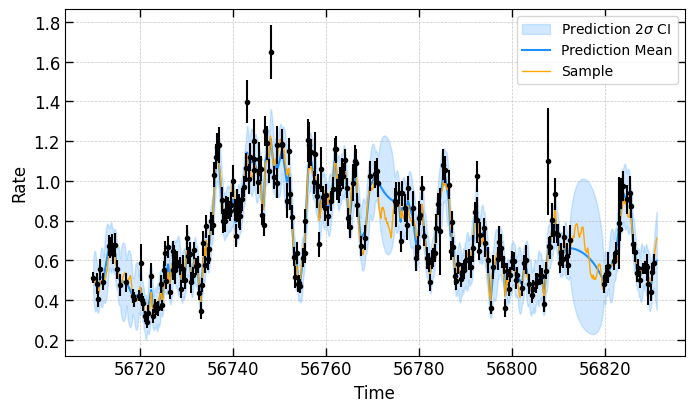

In [58]:
# Visualize the model's prediction, uncertainty, and a sample realization
gp_model.plot()

# Define a regular time grid for prediction and sampling
new_times = np.linspace(lightcurve.times[0], lightcurve.times[-1], 1000, dtype=np.float64)

# Draw 1000 posterior samples from the GP on this grid
# Each realization is a row in the resulting array
samples = gp_model.sample(new_times, num_samples=1000)

# Compute the posterior mean and 2-sigma confidence bounds
predict_mean, lower, upper = gp_model.predict(new_times)

### **Frequency-Resolved Analysis Tools**
---

STELA includes several classes for computing main frequency-resolved data products. These tools help quantify variability, correlation, and time delays between light curves across different timescales/temporal frequencies.

All of the classes listed below follow a similar interface and workflow:

---

#### **Shared Structure and Workflow**

Each class takes as input:
- Either a pair of light curves (`LightCurve` objects), or
- A pair of trained GP models (`GaussianProcess` objects)

If you pass GP models, STELA will automatically use the most recently generated GP samples.  
If you haven’t generated samples yet, the class will generate 1000 by default.

All classes support (via user-defined inputs):
- **Frequency binning** (log or linear)
- **Custom bin edges**
- **Frequency range controls (`fmin`, `fmax`)**
  - Use `fmin="auto"`, `fmax="auto"` to use the minimum and maximum frequency possible given the lightcurve duration, sampling rate.
- A `.plot()` method to quickly visualize the result, including the coherence spectrum for lags.
- An optional `.count_frequencies_in_bins()` method (for diagnostics)

---

#### **What Each Class Computes**

- **PowerSpectrum**  
  Quantifies the variability amplitude in a single light curve as a function of frequency.

- **CrossSpectrum**  
  Measures the complex correlation between two light curves in the frequency domain.

- **LagFrequencySpectrum**  
  Extracts the phase lag between two light curves as a function of frequency. Coherence spectrum also computed.

- **LagEnergySpectrum**  
  Computes the time lag between a broad reference band and several comparison bands (e.g., energy bins), averaged over a specified frequency range. Coherence spectrum also computed.

- **Coherence**  
  Measures how strongly two light curves are linearly related at each frequency (ranges from 0 to 1). Additional coherence from correlated noise can be subtracted using `subtract_bias=True`. This is not needed for GP realizations, which effectively removes the coherence from noise.

---

In the following examples, we’ll show how to use each of these classes:


Detected 1000 samples generated using a Matern12 kernel.


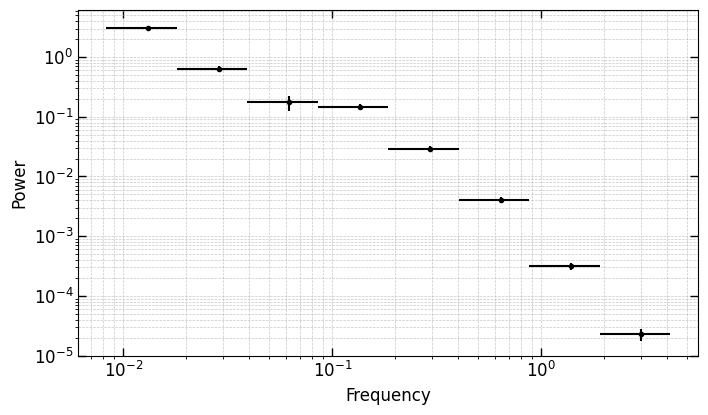

Number of frequencies per bin:
[  2   2   6  12  26  57 124 271]


In [ ]:
# Compute the power spectrum of the light curve
# norm=True (default) for normalization consistent with PSD, otherwise periodogram
ps = PowerSpectrum(gp_model, fmin='auto', fmax='auto', num_bins=8, bin_type='log', norm=True)
ps.plot()

# Access the frequency and power arrays for your own use
freqs = ps.freqs
freq_widths = ps.freq_widths
powers = ps.powers
power_errors = ps.power_errors

# Show how many frequencies are in each bin
print("Number of frequencies per bin:")
print("===============================")
print(ps.count_frequencies_in_bins())

In [88]:
lightcurve_uvw2 = LightCurve(file_path="../data/NGC5548_UVW2_swift.dat")
gp_model_uvw2 = GaussianProcess(lightcurve_uvw2,
                           kernel_form="auto", # consider all kernels available
                           white_noise=True, 
                           enforce_normality=False, 
                        )

Detected 1000 samples generated using a Matern12 kernel.
Detected 1000 samples generated using a Matern32 kernel.


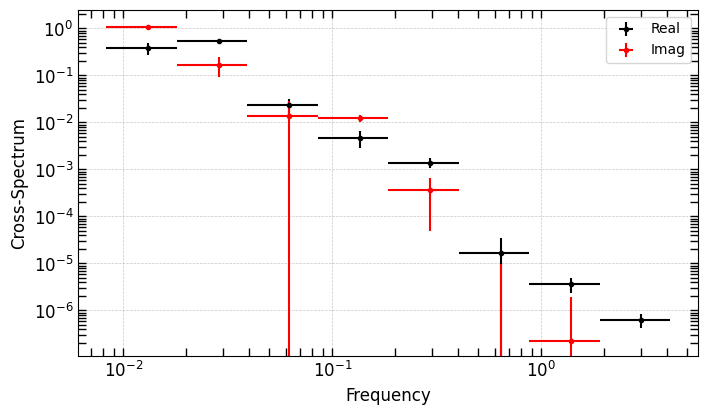

Detected 1000 samples generated using a Matern12 kernel.
Detected 1000 samples generated using a Matern32 kernel.


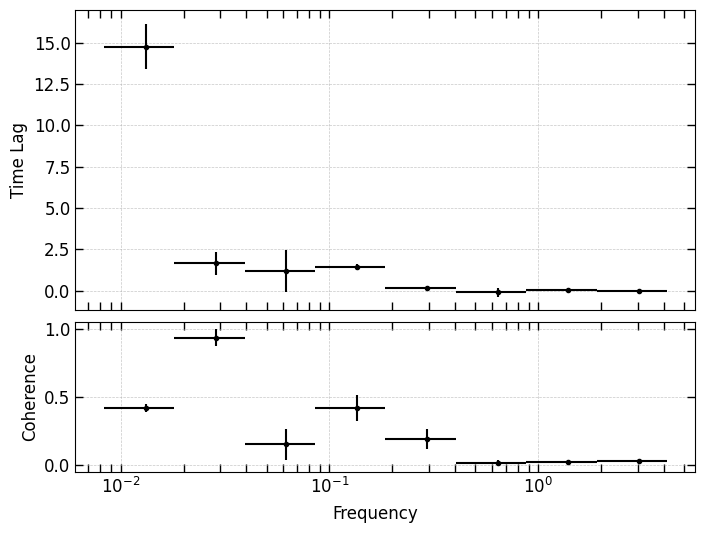

Detected 1000 samples generated using a Matern12 kernel.
Detected 1000 samples generated using a Matern32 kernel.


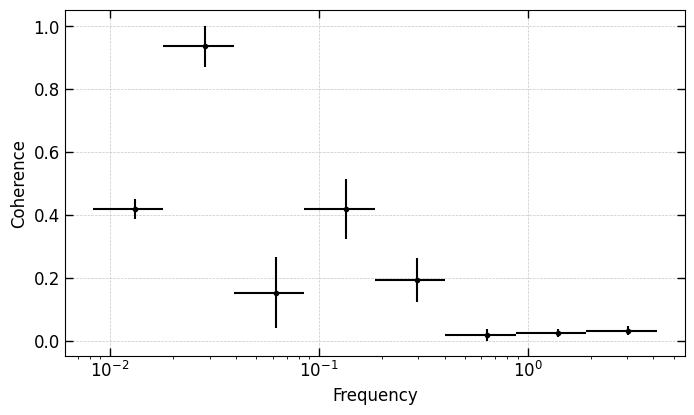

In [114]:
# Generate samples using the same time grid as the other band (important!!)
gp_model_uvw2.sample(new_times, num_samples=1000)

# Compute the cross spectrum between two light curves or GP models
cs = CrossSpectrum(gp_model, gp_model_uvw2, 
                   fmin='auto', fmax='auto',
                   num_bins=8, bin_type='log')
cs.plot()

# Compute the lag-frequency spectrum between two bands
# Positive lag indicates that the first light curve LAGS the second
lag_freq = LagFrequencySpectrum(gp_model, gp_model_uvw2,
                                fmin='auto', fmax='auto',
                                num_bins=8, bin_type='log')
lag_freq.plot()

# Compute the coherence spectrum
coh = Coherence(gp_model, gp_model_uvw2, 
                fmin='auto', fmax='auto',
                num_bins=8, bin_type='log')
coh.plot()
